## How to read a DEM as a Landlab grid

The starting point is to obtain a Digital Elevation Model (DEM) in ESRI's Ascii Grid format, or convert it to this format. The format consists of a 6-line header followed by elevation values. Here we'll work with a small example DEM file 'west_bijou_gully.asc'. The header for this file is as follows:

``ncols        43
nrows        89
xllcorner    559705.000000000000
yllcorner    4380220.000000000000
cellsize     3
NODATA_value 0``

Here, our objective is to translate the contents of this file into a Landlab RasterModelGrid. We'll do this using the ``read_esri_ascii`` function. Here's how it works:


In [2]:
from landlab.io import read_esri_ascii

In the line above, we go to Landlab's input/output library ("io") and import the function. Next, let's look at the basic documentation:

In [3]:
help(read_esri_ascii)

Help on function read_esri_ascii in module landlab.io.esri_ascii:

read_esri_ascii(asc_file, reshape=False, name=None)
    Read :py:class:`~landlab.RasterModelGrid` from an ESRI ASCII file.
    
    Read data from *asc_file*, an ESRI_ ASCII file, into a
    :py:class:`~landlab.RasterModelGrid`.  *asc_file* is either the name of
    the data file or is a file-like object.
    
    The grid and data read from the file are returned as a tuple
    (*grid*, *data*) where *grid* is an instance of
    :py:class:`~landlab.RasterModelGrid` and *data* is a numpy
    array of doubles with that has been reshaped to have the number of rows
    and columns given in the header.
    
    .. _ESRI: http://resources.esri.com/help/9.3/arcgisengine/java/GP_ToolRef/spatial_analyst_tools/esri_ascii_raster_format.htm
    
    Parameters
    ----------
    asc_file : str of file-like
        Data file to read.
    reshape : boolean, optional
        Reshape the returned array, otherwise return a flattened arr

Ok, this tells us we need to supply the name of the file. If we want the data as a 2D array, we also specify ``reshape = True``. If we want to attach the elevation data to the grid as a field, we also give a name for the field as the ``name`` parameter. For example:

In [4]:
(mg, z) = read_esri_ascii('west_bijou_gully.asc', name='elevation')

Let's plot the grid:

In [7]:
from landlab.plot.imshow import imshow_node_grid

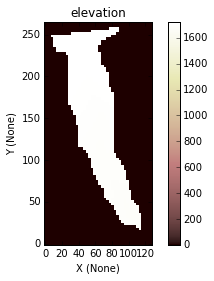

In [10]:
%matplotlib inline
imshow_node_grid(mg, 'elevation')

We can also query a bit of information:

In [12]:
mg.number_of_node_rows

89

In [13]:
mg.number_of_node_columns

43

Since we have a lot of NODATA nodes (outside the watershed), let's make these closed boundaries. The following line says: find all the nodes where z=0 and set them to closed boundary status.

In [14]:
mg.set_nodata_nodes_to_closed(z, 0)